# 1.INSTALLATION

In [1]:
!pip install gym[atari,accept-rom-license]
!pip install ffmpeg
!pip install imageio-ffmpeg

# 2. Deep Q Network with Cartpole

DQN was created by DeepMind researchers, achieving superhuman performance on many Atari games (https://deepmind.com/research/dqn/). What made the accomplishments of DQN even more impressive is that the DQN had nearly the same architecture and hyperparameter settings for each game (ie no game specific knowledge or set up) and the only inputs to the DQN were the screen pixels.

The main parts of the DQN are Q learning, the neural net, experience replay, target network updating, and data/environment pre-processing. For the neural net in this example, we replaced the Convolutional Neural Net (CNN) used in the original DQN with a 2 layer feed forward neural network (FFNN). We use the FFNN since CartPole doesn't give us image data. We'll use the CNN and data/environment pre-processing in the Pong DQN example


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

from gym import spaces
from collections import deque
import cv2
cv2.ocl.setUseOpenCL(False)

In [3]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Experience Replay Buffer

Q learning is an off-policy method. In off-policy methods we often save samples and then train on them. DQN has a memory buffer that stores state, action, reward, done condition, and next state samples. In the training loop, DQN will sample from this memory buffer and train on the saved samples. The replay buffer is essentially a queue that we randomly sample from. When the queue gets full we replace the first element of the queue. 

In [4]:
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            if type(X) is tuple:
                X = X[0]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u).reshape(-1,1), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

### Feed Forward Neural Network

We use a simple FFNN for the function approximator. We create two linear, dense (fully-connected) layers and use a ReLU activation function. Note the input is the state size of the environment and the output is the action size of the environment. The outputs of the neural net are the estimated Q values based on the state input.

In [5]:
class FeedForwardNeuralNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(FeedForwardNeuralNet, self).__init__()
        self.dense_layer_1 =  nn.Linear(state_size, hidden_size)
        self.dense_layer_2 =  nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x =  self.dense_layer_1(x)
        x =  self.dense_layer_2(x)
        return self.output(x)

### CartPoleAgent Class

We create a CartPoleAgent class. The agent has a train network for learning a policy and a target network for performing target network updates. The agent has a select_action() function for sampling an action based on the epsilon-greedy method. The agent has a train() function, in which the agent samples from the replay buffer and updates the neural network parameters to improve its policy. The agent also has a update_target_network() function for updating the target network parameters with the training network parameters.

In [6]:
class CartPoleAgent():
    def __init__(self, state_size, action_size, hidden_size, learning_rate):
        
        self.action_size = action_size
        #define the networks (don't forget .to(device))

        self.train_net = FeedForwardNeuralNet(state_size, action_size, hidden_size).to(device)
        self.target_net =  FeedForwardNeuralNet(state_size, action_size, hidden_size).to(device)
        
        self.target_net.load_state_dict(self.train_net.state_dict())
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=learning_rate)
        
    def select_action(self, state, epsilon):
        # select action according to epsilon-greedy method (similar to last practical session but now in PyTorch)
        if np.random.rand() < epsilon:

            action =  np.random.randint(self.action_size)

        else:
            # greedy action is the largest Q value from the train network based on the input
            with torch.no_grad():
                if type(state) is tuple:
                    state = state[0]
                input_state = torch.FloatTensor(state).to(device)
                # feed input into the network and get the max action value
                values = self.target_net(input_state)
                action = torch.argmax(values).item()

        return action

    
    def train(self, replay_buffer, batch_size, discount):
        # train the training network
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)

        # turn batches into tensors and attack to GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.LongTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        done_batch = torch.FloatTensor(1 - d).to(device)

        # get train net Q values

        train_q =  self.train_net(state_batch).gather(1, action_batch)
        
        # get target net Qvalues
        with torch.no_grad():

            target_net_q = self.target_net(next_state_batch).max(1)[0].unsqueeze(1)
            target_net_q = reward_batch + (done_batch * discount * target_net_q)
            #FILL (don't forget to use the Bellman optimality equation to compute the target Qvalues!)

        # create loss function

        loss_fn = nn.MSELoss()
        #FILL (MSE for example)

        # compute loss between train q values and target q values
        loss = loss_fn(train_q, target_net_q)
        # optimize the parameters with the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # we return the loss so we can monitor loss and debug the network if necessary
        return loss.detach().cpu().numpy()
    
    
    def update_target_network(self, num_iter, update_every):
        # update target network every so often
        # hard target network update: updates target network fully with train network params
        if num_iter % update_every == 0:
            self.target_net.load_state_dict(self.train_net.state_dict())
            

### Target Network Updating

DQN has two networks: a train network and a target network. The target network provides the next-state Q values for the Q learning update. We use the next-state Q values to update the train network. Periodically we then update target network variables with the train network variables. Using a target network increases stability and convergence of the DQN.

### Hyperparameters

Hyperparameters are a variety of arguments that are usually tuned to help produce the best performing agents. Hyperparameter choice can be tricky as poor hyperparameter choice can prevent an agent from learning anything. The best choice depends on the algorithm and problem. Two basic methods that are used are random search, where you randomly pick hyperparameter values from a predefined range of values, and grid search where you systematically try all values and combinations based on a predefined grid of values.

In [7]:
# initialize environment
env = gym.make('CartPole-v0')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
#env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 1000 # run agent for this many episodes
start_training_after = 100 # collect data for this many timesteps before training
hidden_size = 64 # number of units in NN hidden layers
learning_rate = 0.0005 # learning rate for optimizer
update_target_every_ts = 1000 # update target network after this many steps
batch_size = 64 # mini batch size we train network on
discount = 0.9 # gamma value

epsilon_start = 1.0 # epsilon start value
epsilon_min = 0.01  # epsilon end value
epsilon_decay_steps = episodes * .15 # decay epsilon over this many episodes
epsilon_step = (epsilon_start - epsilon_min)/(epsilon_decay_steps) # decrement epsilon by this amount every timestep

# create replay buffer
replay_size = 15000
replay_buffer = ReplayBuffer(max_size=replay_size)

# create cartpole agent
cartpole_agent = CartPoleAgent(state_size, action_size, hidden_size, learning_rate)
        

/home/jose/miniconda3/envs/ml/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


### The RL Training Loop

In the loop, we iterate through our episodes and then the timesteps within the episodes. We stop training the agent based on some stopping condition like a max episode value, a max timestep value, or the agent's performance reaches a certain level.

In each episode and at each timestep the agent selects an action, calls env.step(), and stores the sample in the replay buffer. The agent will also train the training neural network and periodically update the target network. When an episode is done the env is reset.

In [8]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
epsilon = epsilon_start

for ep in range(episodes):
    state = env.reset()
    stats_loss = 0
    
    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  
    
    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy

        action = cartpole_agent.select_action(state, epsilon)

        # enter action into the env

        next_state, reward, done, _, _ =  env.step(action)

        total_reward += reward
        episode_length += 1
        
        if done:
            next_state = np.zeros(state.shape)
            reward = -1
            # add experience to replay buffer
            
            replay_buffer.add((state, next_state, action, reward, done))
            
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0
            
            epsilon -= epsilon_step
            if epsilon < epsilon_min:
                epsilon = epsilon_min
                
            if timesteps > start_training_after and ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Epsilon: {:.2f}'.format(epsilon),
                    'Loss: {:.3f}'.format(stats_loss))
                
            break
        else:
            # add experience to replay buffer
            replay_buffer.add((state, next_state, action, reward, done))
        
        state = next_state
        if timesteps > start_training_after:
            # train the agent
            stats_loss += cartpole_agent.train(replay_buffer, batch_size, discount)

            # update the target network every (if conditions are met in update_target_network)

            cartpole_agent.update_target_network(timesteps, update_target_every_ts)

/home/jose/miniconda3/envs/ml/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 10 Timestep: 217 Total reward: 20.2 Episode length: 20.2 Epsilon: 0.93 Loss: 2.381
Episode: 20 Timestep: 514 Total reward: 29.7 Episode length: 29.7 Epsilon: 0.86 Loss: 6.271
Episode: 30 Timestep: 853 Total reward: 33.9 Episode length: 33.9 Epsilon: 0.80 Loss: 6.194
Episode: 40 Timestep: 1116 Total reward: 26.3 Episode length: 26.3 Epsilon: 0.73 Loss: 3.806
Episode: 50 Timestep: 1290 Total reward: 17.4 Episode length: 17.4 Epsilon: 0.66 Loss: 5.310
Episode: 60 Timestep: 1459 Total reward: 16.9 Episode length: 16.9 Epsilon: 0.60 Loss: 3.148
Episode: 70 Timestep: 1642 Total reward: 18.3 Episode length: 18.3 Epsilon: 0.53 Loss: 7.456
Episode: 80 Timestep: 1840 Total reward: 19.8 Episode length: 19.8 Epsilon: 0.47 Loss: 6.829
Episode: 90 Timestep: 1969 Total reward: 12.9 Episode length: 12.9 Epsilon: 0.40 Loss: 6.578
Episode: 100 Timestep: 2121 Total reward: 15.2 Episode length: 15.2 Epsilon: 0.33 Loss: 3.380
Episode: 110 Timestep: 2308 Total reward: 18.7 Episode length: 18.7 Epsi

Text(0, 0.5, 'Episode Reward')

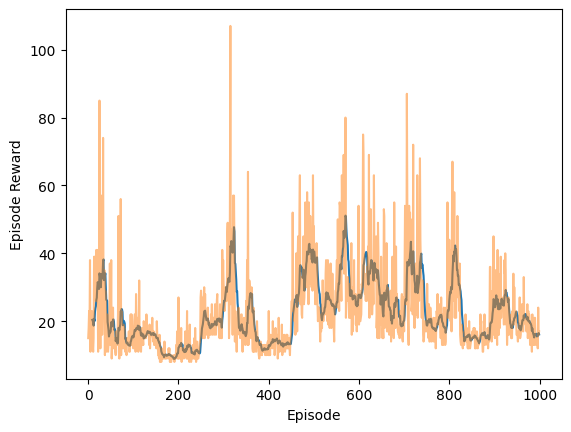

In [9]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

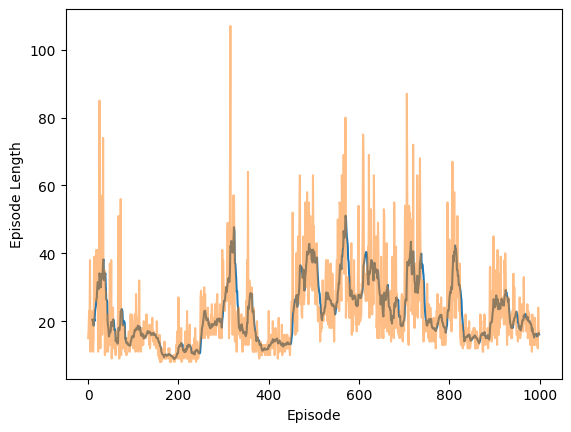

In [10]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')

# 3. DQN with Pong

### Environment Wrappers

Wrappers modify gym environments. Wrappers can change the observation, reward, done, and info returns. Wrappers can also change the gym functions like step() and reset(). We include and use some common wrappers used in Atari games in the cells below. To use a wrapper, feed the gym env into the wrapper function like in the next cell. Sometimes problems require their own customized wrappers.

In [11]:
#Use like this: 
#env = gym.make('PongNoFrameskip-v4')
#env = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False) #scale in DQN

In [12]:
# from: https://github.com/openai/baselines/baselines/common/atari_wrappers.py
# from: https://github.com/Officium/RL-Experiments/blob/master/src/common/wrappers.py 

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info, _ = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if 0 < lives < self.lives:
            # for Qbert sometimes we stay in lives == 0 condition for a few
            # frames so it's important to keep lives > 0, so that we only reset
            # once the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        shape = (2, ) + env.observation_space.shape
        self._obs_buffer = np.zeros(shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = info = None
        for i in range(self._skip):
            obs, reward, done, info, _ = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    @staticmethod
    def reward(reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height
        self.grayscale = grayscale
        shape = (1 if self.grayscale else 3, self.height, self.width)
        self.observation_space = spaces.Box(
            low=0, high=255, shape=shape, dtype=np.uint8
        )

    def observation(self, frame):
        if self.grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        size = (self.width, self.height)
        frame = cv2.resize(frame, size, interpolation=cv2.INTER_AREA)
        if self.grayscale:
            frame = np.expand_dims(frame, -1)
        return frame.transpose((2, 0, 1))


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also `LazyFrames`
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        shape = (shp[0] * k, ) + shp[1:]
        self.observation_space = spaces.Box(
            low=0, high=255, shape=shape, dtype=env.observation_space.dtype
        )

    def reset(self):
        ob = self.env.reset()
        print(ob.shape)
        for _ in range(self.k):
            self.frames.append(ob)
        return np.asarray(self._get_ob())

    def step(self, action):
        ob, reward, done, info, _ = self.env.step(action)
        self.frames.append(ob)
        return np.asarray(self._get_ob()), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are
        only stored once. It exists purely to optimize memory usage which can be
        huge for DQN's 1M frames replay buffers.
        This object should only be converted to numpy array before being passed
        to the model. You'd not believe how complex the previous solution was.
        """
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-3)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0
    
    
def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env, width=84, height=84)
    env = MaxAndSkipEnv(env, skip=4)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

### Pong

In this notebook we'll train an agent to play the classic Atari game Pong. In Pong the agent controls a paddle and tries to hit a ball past the opponents paddle to score a point. The agent gets a positive reward when scoring a point and a negative reward when the opponent scores a point. The episode ends when a set number of points are reached.

In [13]:
from gym.wrappers import RecordVideo
import os


#create Pong env and test it a bit
env = gym.make('ALE/Pong-v5', frameskip=1, render_mode='rgb_array')
env = RecordVideo(env, video_folder='./content/')
env.reset()

for i in range(10000):
    action = env.action_space.sample()
    next_state, reward, done, info, _ = env.step(action)
    if done:
        env.reset()
        print('done')
env.close()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/jose/miniconda3/envs/ml/lib/python3.9/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/jose/Desktop/Lorenc1o-repos/BDMA_Notes/Paris-Saclay/Machine-Learning/Labs/L7/content folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/jose/miniconda3/envs/ml/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/home/jose/miniconda3/envs/ml/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video /home/jose/Desktop/Lorenc1o-repos/BDMA_Notes/Paris-Saclay/Machine-Learning/Labs/L7/content/rl-video-episode-0.mp4.
Moviepy - Writing video /home/jose/Desktop/Lorenc1o-repos/BDMA_Notes/Paris-Saclay/Machine-Learning/Labs/L7/content/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/jose/Desktop/Lorenc1o-repos/BDMA_Notes/Paris-Saclay/Machine-Learning/Labs/L7/content/rl-video-episode-0.mp4
done
Moviepy - Building video /home/jose/Desktop/Lorenc1o-repos/BDMA_Notes/Paris-Saclay/Machine-Learning/Labs/L7/content/rl-video-episode-1.mp4.
Moviepy - Writing video /home/jose/Desktop/Lorenc1o-repos/BDMA_Notes/Paris-Saclay/Machine-Learning/Labs/L7/content/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/jose/Desktop/Lorenc1o-repos/BDMA_Notes/Paris-Saclay/Machine-Learning/Labs/L7/content/rl-video-episode-1.mp4
done


In [20]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('content/rl-video-episode-0.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [15]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('content/rl-video-episode-1.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Deep Q Network

The Deep Q Network is from the original DQN paper and is sometimes referred to as the Nature CNN (since the article was published in Nature). Compared to state of the art CNNs in image recognition, the Nature CNN is quite simple. There are only three convolutional layers (of kernel size 8, 4 and 3; stride 4, 2 and 1; 32 filters in the first and 64 in the two others), followed by a fully connected (dense) layer and a linear layer. All but the linear layer have ReLU activations.

In [21]:
# create Deep Q Network Class by inheriting from torch.nn.Module
# based on Nature CNN from OpenAI baselines: https://github.com/openai/baselines/blob/1b092434fc51efcb25d6650e287f07634ada1e08/baselines/common/models.py
            
class DeepQNetwork(nn.Module):
    def __init__(self, action_size, hidden_size):
        super(DeepQNetwork, self).__init__()
        self.conv_layer_1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv_layer_2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) 
        self.conv_layer_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.dense_layer = nn.Linear(7*7*64, hidden_size) 
        self.out_layer = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = x / 255. # image data is stored as ints in 0 to 255 range. Divide to scale to 0 to 1 range
        x = F.relu(self.conv_layer_1(x))
        x = F.relu(self.conv_layer_2(x))
        x = F.relu(self.conv_layer_3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.dense_layer(x))
        return self.out_layer(x)

### DQNAgent Class

We create a DQNAgent class. The agent has a train network for learning a policy and a target network for performing target network updates. The agent has a select_action() function for sampling an action based on the epsilon-greedy method. The agent has a train() function, in which the agent samples from the replay buffer and updates the neural network parameters to improve its policy. The agent also has a update_target_network() function for updating the target network parameters with the training network parameters.

In [22]:
# REUSE AND MODIFY THE PREVIOUS AGENT CLASS TO CHANGE THE NETWORK TO DQN

class PongAgent():
    def __init__(self, action_size, hidden_size, learning_rate):
        
        self.action_size = action_size
        #define the networks (don't forget .to(device))

        self.train_net = DeepQNetwork(action_size, hidden_size).to(device)
        self.target_net =  DeepQNetwork(action_size, hidden_size).to(device)
        
        self.target_net.load_state_dict(self.train_net.state_dict())
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=learning_rate)
        
    def select_action(self, state, epsilon):
        # select action according to epsilon-greedy method (similar to last practical session but now in PyTorch)
        if np.random.rand() < epsilon:

            action =  np.random.randint(self.action_size)

        else:
            # greedy action is the largest Q value from the train network based on the input
            with torch.no_grad():
                if type(state) is tuple:
                    state = state[0]
                input_state = torch.FloatTensor(state).to(device)
                # feed input into the network and get the max action value
                values = self.target_net(input_state)
                action = torch.argmax(values).item()

        return action

    
    def train(self, replay_buffer, batch_size, discount):
        # train the training network
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)

        # turn batches into tensors and attack to GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.LongTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        done_batch = torch.FloatTensor(1 - d).to(device)

        # get train net Q values

        train_q =  self.train_net(state_batch).gather(1, action_batch)
        
        # get target net Qvalues
        with torch.no_grad():

            target_net_q = self.target_net(next_state_batch).max(1)[0].unsqueeze(1)
            target_net_q = reward_batch + (done_batch * discount * target_net_q)
            #FILL (don't forget to use the Bellman optimality equation to compute the target Qvalues!)

        # create loss function

        loss_fn = nn.MSELoss()
        #FILL (MSE for example)

        # compute loss between train q values and target q values
        loss = loss_fn(train_q, target_net_q)
        # optimize the parameters with the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # we return the loss so we can monitor loss and debug the network if necessary
        return loss.detach().cpu().numpy()
    
    
    def update_target_network(self, num_iter, update_every):
        # update target network every so often
        # hard target network update: updates target network fully with train network params
        if num_iter % update_every == 0:
            self.target_net.load_state_dict(self.train_net.state_dict())
            

### Hyperparameters

Hyperparameters are a variety of arguments that are usually tuned to help produce the best performing agents. Hyperparameter choice can be tricky as poor hyperparameter choice can prevent an agent from learning anything. The best choice depends on the algorithm and problem. Two basic methods that are used are random search, where you randomly pick hyperparameter values from a predefined range of values, and grid search where you systematically try all values and combinations based on a predefined grid of values.

In [23]:
# Initialize env and set up hyperparameters
env = gym.make('ALE/Pong-v5', frameskip=1, render_mode='rgb_array')
env = RecordVideo(env, video_folder='./content/')


# wrap env
env = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False)
action_size = env.action_space.n

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
timesteps = 2000000 # run env for this many time steps
hidden_size = 512   # side of hidden layer of FFNN that connects CNN to outputs
learning_rate = 0.0001 # learning rate of optimizer
batch_size = 32    # size of batch trained on
start_training_after = 10001 # start training NN after this many timesteps
discount = 0.99 # discount future states by

epsilon_start = 1.0 # epsilon greedy start value
epsilon_min = 0.01  # epsilon greedy end value
epsilon_decay_steps = timesteps * .15 # decay epsilon over this many timesteps
epsilon_step = (epsilon_start - epsilon_min)/(epsilon_decay_steps) # decrement epsilon by this amount every timestep

update_target_every = 1000 # update target network every this steps

# create replay buffer
replay_size = 50000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)

# create DQN Agent
dqn_agent = PongAgent(action_size, hidden_size, learning_rate)

### The RL Training Loop

In the loop, we iterate through our episodes and then the timesteps within the episodes. We stop training the agent based on some stopping condition like a max episode value, a max timestep value, or if the agent's performance reaches a certain level.

In each episode and at each timestep the agent selects an action, calls env.step(), and stores the sample in the replay buffer. The agent will also train the training neural network and periodically update the target network. When an episode is done the env is reset.

In [24]:
# Reuse the training loop above and replace with the new agent and environment

stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
epsilon = epsilon_start

for ep in range(episodes):
    state = env.reset()
    stats_loss = 0
    
    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  
    
    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy

        action = dqn_agent.select_action(state, epsilon)

        # enter action into the env

        next_state, reward, done, _, _ =  env.step(action)

        total_reward += reward
        episode_length += 1
        
        if done:
            next_state = np.zeros(state.shape)
            reward = -1
            # add experience to replay buffer
            
            replay_buffer.add((state, next_state, action, reward, done))
            
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0
            
            epsilon -= epsilon_step
            if epsilon < epsilon_min:
                epsilon = epsilon_min
                
            if timesteps > start_training_after and ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Epsilon: {:.2f}'.format(epsilon),
                    'Loss: {:.3f}'.format(stats_loss))
                
            break
        else:
            # add experience to replay buffer
            replay_buffer.add((state, next_state, action, reward, done))
        
        state = next_state
        if timesteps > start_training_after:
            # train the agent
            stats_loss += cartpole_agent.train(replay_buffer, batch_size, discount)

            # update the target network every (if conditions are met in update_target_network)

            dqn_agent.update_target_network(timesteps, update_target_every_ts)

ValueError: too many values to unpack (expected 2)

In [ ]:
gym.__version__

'0.26.2'

In [ ]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

In [ ]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')

# 4. Double DQN with Pong

Modify the code to implement double DQN and run training again to observe improvements (hint: change how target values are computed in DQNAgent, only requires two lines of code)

# 5. Duelling DQN with Pong

Modify the code to implement duelling DQN and run training again to observe improvements (hint: change the Deep Q-Network)